In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/jkrieger/work/ray_tracing/python')
import mantaray
import math

In [2]:
g = 9.8
def period2wavenumber(T):
    k = (2*np.pi)**2/g/T**2
    return k

def group_velocity(k):
    cg = 0.5*(g/k)**.5
    return cg

In [3]:
ww_2021 = xr.load_dataset('/Users/jkrieger/work/member-Krieger/saildrone_analysis/smode_data/WW3_SMODE_Pilot.nc')

In [4]:
start_date = '2021-10-30T11:00:00.000000000' # start date and time of front
end_date = '2021-10-30T22:00:00.000000000' # end date and time of front
ww_slice = ww_2021.sel(time=slice(start_date, end_date))

In [5]:
def haversine(coord1, coord2):
    '''
    This outputs the distance in meters between two lat/lon coordinates.
    '''
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [6]:
# Length of domain in meters
Lx = haversine((ww_slice.latitude[0], ww_slice.longitude[0]), (ww_slice.latitude[0], ww_slice.longitude[-1]))
Ly = haversine((ww_slice.latitude[0], ww_slice.longitude[0]), (ww_slice.latitude[-1], ww_slice.longitude[0]))

# grid spacing
dx = haversine((ww_slice.latitude[0], ww_slice.longitude[0]), (ww_slice.latitude[0], ww_slice.longitude[1]))
dy = haversine((ww_slice.latitude[0], ww_slice.longitude[0]), (ww_slice.latitude[1], ww_slice.longitude[0]))

# hs vals
hs = ww_slice.hs[0,:,:].values

y = np.arange(0, Ly/1000, dy/1000)  # Ensures correct size
x = np.arange(0, Lx/1000+(dx/1000), dx/1000)  # Ensures correct size

Umax = np.nanmax(np.sqrt((ww_slice.ucur[0,:,:].values)**2+(ww_slice.vcur[0,:,:].values)**2))

nx, ny = len(x), len(y)

xc = np.linspace(0, 1, ny)
u = ww_slice.ucur[0,:,:].values
v = ww_slice.vcur[0,:,:].values

In [7]:
ds = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "hs": (["y", "x"], hs, {"long_name": "hs", "units": "m"}),
        "u": (["y", "x"], u, {"long_name": "u", "units": "m/s"}),
        "v": (["y", "x"], v, {"long_name": "v", "units": "m/s"}),
    })
#ds.to_netcdf('large_scale_wavewatch_refraction_slice.nc', format="NETCDF3_CLASSIC")

# Considering a constant depth of 4km
D = 4e3 
depth = D*np.ones((ny, nx))

ds = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "depth": (["y", "x"], depth, {"long_name": "depth", "units": "m"}),
    })
#ds.to_netcdf('wavewatch_refraction_slice_bathymetry.nc', format="NETCDF3_CLASSIC")

# Initialize wave parameters

In [36]:
# Period of incident waves in seconds
T0 = 11

# Direction of incident waves in radians (trig convention, going to)
theta_deg = 306.4
theta0 = 0 #theta_deg * (np.pi/180)

# Convert period to wavenumber magnitude
k0 = period2wavenumber(T0)

# Calculate wavenumber components
kx0 = k0*np.cos(theta0)
ky0 = k0*np.sin(theta0)

# Number of rays
n_rays = 100

# Initialize wavenumber for all rays
Kx0 = kx0*np.ones(n_rays)
Ky0 = ky0*np.ones(n_rays)

# Current and bathymetry file path
bathymetry = 'data/bathymetry/wavewatch_refraction_slice_bathymetry.nc'
current = 'data/currents/wavewatch_refraction_slice.nc'
large_scale_currents = 'data/currents/large_scale_wavewatch_refraction_slice.nc'

ds = xr.open_dataset(large_scale_currents)

x = ds.x.values
y = ds.y.values

# Creates initial x position for all rays
#x0 = np.linspace(5, 500, num=n_rays)  # 100 rays spread from 0 to 175 in x
#y0 = np.full_like(x0, 220)  # Set y positions at 220
x0 = 10*np.ones(n_rays)
y0 = np.linspace(5, y.max(), n_rays)

# Estimates CFL
# Computes grid smallest spacing
dd = np.min([np.diff(x).mean(), np.diff(y).mean()])

# Computes group velocity
cg = group_velocity(k0)

# Computes CFL
cfl = dd/cg

duration = round(x.max()/cg)
step_size = cfl

# Initialize ray tracing and ray positions

In [37]:
bundle = mantaray.ray_tracing(x0, y0, Kx0, Ky0, duration, step_size, bathymetry, current)

Text(0.5, 1.0, 'WAVEWATCH currents with ray tracing')

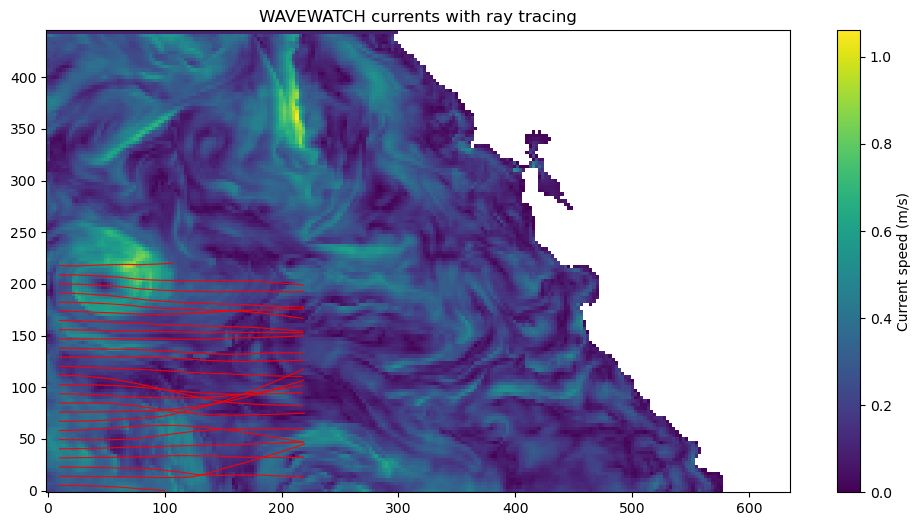

In [38]:
X = ds.x
Y = ds.y
U = (ds.u**2 + ds.v**2)**.5
hs = ds.hs
plt.figure(figsize=(12, 6))
cs = plt.pcolormesh(X, Y, U)
for i in range(bundle.ray.size)[::2]:
    ray = bundle.isel(ray=i)
    plt.plot(ray.x, ray.y, 'red', lw=.78)
#plt.scatter(sd_x_meters, sd_y_meters, c=non_masked, marker='o', label='SD 1062 data')
#plt.legend(loc='upper right')
plt.colorbar(cs, label='Current speed (m/s)')
plt.title('WAVEWATCH currents with ray tracing')

Text(0.5, 1.0, 'WAVEWATCH H_s with ray tracing')

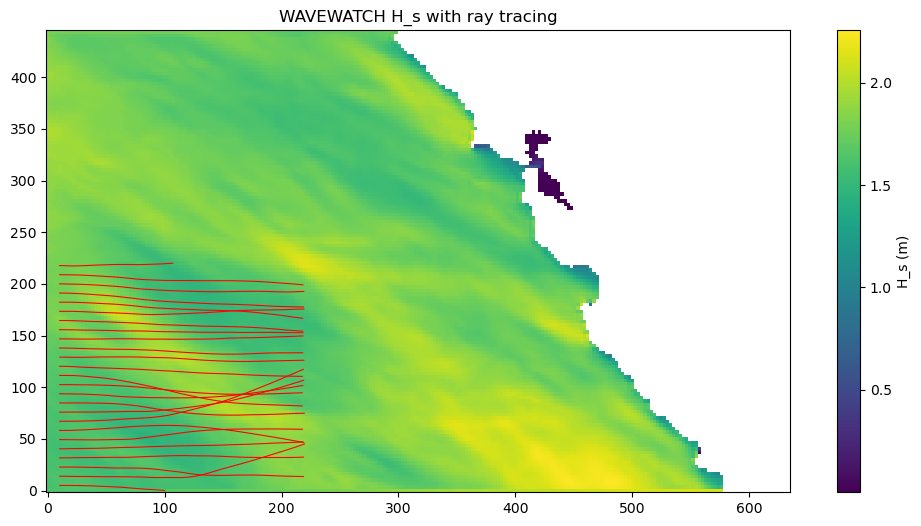

In [39]:
X = ds.x
Y = ds.y
U = (ds.u**2 + ds.v**2)**.5
hs = ds.hs
plt.figure(figsize=(12, 6))
cs = plt.pcolormesh(X, Y, hs)
for i in range(bundle.ray.size)[::2]:
    ray = bundle.isel(ray=i)
    plt.plot(ray.x, ray.y, 'red', lw=.78)
#plt.scatter(sd_x_meters, sd_y_meters, c=non_masked, marker='o', label='SD 1062 data')
#plt.legend(loc='upper right')
plt.colorbar(cs, label='H_s (m)')
plt.title('WAVEWATCH H_s with ray tracing')